# Objective 
Illustrate mechanisms within `sagemaker` and Azure ML to preprocess data sets: 

a. interactively for exploratory data analysis.

b. in script mode (programmatically). 

# Introduction

Data is not always ready for analysis, we need to be able to quickly inspect data (as close to the source) as possible so we can get a sense of:
 - Missing Data
 - Inconsistent Data
 - Skew
 - Outliers
 - Duplicates
 - Biased Data

Interactive data access could be used to understand the contours of data (i.e., assess data quality), identify issues (e.g., missing values, outliers) and select relevant features. Exploration fueled by interactive data access is a precursor to the programmatic execution of data pre-processing jobs that read raw data and write processed data.

![preprocess](assets/preprocess.drawio.png)

<div class="alert alert-block alert-warning">

<b>Business Context</b> 
    
For this session consider the case of a popular diamond jeweller - Brilliant Earth - with 30 showrooms across the US facing a price prediction problem. A common customer question that echoes in their retail outlets is the impact on price because of changes in some aspects of the ornament. For example, usually customers ask: "If I decreased the carat of the diamonds used in this design, by how much would the price reduce?". Such queries often require an expert intervention on the shopfloor and result in a subdued customer experience. The company also wants to implement a price predictor tool on their website so customers can engage with the brand better. At the moment, no such tool exists and the business team estimates that a price predictor will improve traffic to the website and also improve the time spent on the website.

The dataset used in this session is scraped from the [Brilliant Earth website](https://www.brilliantearth.com/) and hosted on [Open ML](https://www.openml.org/search?type=data&status=active&id=43355). This data is stored in a S3 bucket.

</div>

An effective way to work with the `sagemaker` ecosystem is to use the `sagemaker` Python SDK to interface with several resources that underpin the ecosystem. This SDK is preinstalled in SageMaker Studio. Similarly, an effective way to work with the Azure ML ecosystem is to use the Python SDK (we use version 2).

If the `sagemaker`/`azureml` package is used with tools beyond SageMaker Studio/Azure ML Studio (e.g., Visual Studio Code or local JupyterLab), ensure that proper access permissions (e.g., access keys) are provided to the tool.

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('talk')

## AWS

In [3]:
import sagemaker
from sagemaker.sklearn.processing import SKLearnProcessor

from sagemaker.processing import ProcessingInput, ProcessingOutput

A `sagemaker` session is a cloud equivalent to a fully functional local development setup (i.e., access enabled to data and compute). We can point a session to a default bucket that will host all the artifacts accessed and created during the session (remember nothing stays local). 

In [4]:
session = sagemaker.Session()

In [5]:
try:
    aws_role = sagemaker.get_execution_role()
except ValueError:
    print("Config file not found on local machine, use SageMaker Studio")

From within SageMaker studio, execution role is inherited. Outside the Studio environment, the execution role should be explictly specified. This execution role should have [AmazonSageMakerFullAccess](https://docs.aws.amazon.com/sagemaker/latest/dg/security-iam-awsmanpol.html) permissions. Local compute [access](https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-files.html) should also be [enabled](https://stackoverflow.com/a/47767351).

In [6]:
print(f"AWS execution role associated with the account {aws_role}")
print(f"Default bucket associated with the account: {session.default_bucket()}")
print(f"Default boto region associated with the account: {session.boto_region_name}")

AWS execution role associated with the account arn:aws:iam::321112151583:role/default-sagemaker-access
Default bucket associated with the account: sagemaker-ap-south-1-321112151583
Default boto region associated with the account: ap-south-1


We want this session to write data assets to a custom bucket, so we specify a default S3 bucket.

In [7]:
preprocessing_session = sagemaker.Session(
    default_bucket="sagemaker-processing-example"
)

In [8]:
preprocessing_session.default_bucket()

'sagemaker-processing-example'

Notice how the default bucket is now changed.

## Azure

In [1]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

from azure.ai.ml import Input, Output
from azure.ai.ml import command

In [2]:
subscription_id = "5bcad9c4-40fb-4136-b614-cc90116dd8b3"
resource_group = "tf"
workspace = "cloud-teach"

From VMs within the Azure ML workspace, the default Azure credentials are inherited. However, interactive browser credentials could be used to authenticate an Azure account to the Azure ML workspace.

In [3]:
az_credentials = DefaultAzureCredential(
    exclude_interactive_browser_credential=False
)

In [4]:
ml_client = MLClient(
    az_credentials, subscription_id, resource_group, workspace
)

# Exploratory Data Analysis

Before we plan a full-fledged data processing pipeline, we will want to interact with data sets stored in cloud stores for exploratory analysis.

## Cloud File Systems (`fsspec`)

![fsspec](assets/fsspec.drawio.png)

The [cloud file system specification (`fsspec`)](https://filesystem-spec.readthedocs.io/en/latest/?badge=latest) is a Python library developed to provide a unified interface for accessing various file storage systems, including those offered by AWS and Azure.

`fsspec` aims to abstract away the differences between different cloud storage providers, local file systems, and other remote storage systems. It allows developers to interact with these storage systems using a common set of methods and handles various functionalities like reading, writing, and managing files.

When it comes to AWS and Azure, both cloud providers offer their own file storage services. AWS provides Amazon S3 (Simple Storage Service) and Azure offers Azure Blob Storage. These services are object storage solutions that allow you to store and retrieve large amounts of unstructured data.

With `fsspec`, you can interact with AWS S3 and Azure Blob Storage using a consistent API, regardless of the underlying implementation details. This means that you can write code that works with both AWS and Azure storage systems without having to change the code for each provider (e.g., `pd.read_csv` that takes S3 location *or* Azure blob store location as the input).

`fsspec` provides a set of core classes and functions that define the interface for file operations. It supports features like file listing, reading and writing files, handling directories, and metadata operations. By utilizing fsspec, developers can seamlessly switch between different storage systems without rewriting their code.

Once `fsspec` is installed (`pip install fsspec`), we can read the data stored in cloud services (e.g., S3) as if we were accessing a local file, without worrying about the specifics of the cloud file systems.

## AWS

While `fsspec` handles the file system abstractions, we will still need to connect AWS S3 credentials to allow for file system access. This is achieved through the [`s3fs` package](https://github.com/fsspec/s3fs.git) (`pip install s3fs`). [Caveat: current version of `s3fs` is pinned to a previous version of AWS dependencies](https://github.com/fsspec/s3fs/issues/528). It is recommended that this package be installed in its own environment so it does not break `sagemaker` dependencies. 

For interactive data access on small datasets in `S3`, `pandas` could be used to directly read data from the `S3` location (the processor is handy for a read/write workflow that we will see shortly). In this case, the dataset is in a folder within the default bucket of the `sagemaker` account (remember we changed the defult bucket).

In [13]:
diamond_prices = pd.read_csv("s3://sagemaker-ap-south-1-321112151583/prices/diamond-prices.csv")

As the above code indicates, pandas is able to read a file from S3 using the familiar `read_csv` function. Behind the scenes, pandas uses `fsspec` to access the cloud file system and `s3fs` to get access to this file system.

In [14]:
diamond_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            119307 non-null  float64
 1   url           119307 non-null  object 
 2   shape         119307 non-null  object 
 3   price         119307 non-null  float64
 4   carat         119307 non-null  float64
 5   cut           119307 non-null  object 
 6   color         119307 non-null  object 
 7   clarity       119307 non-null  object 
 8   report        119307 non-null  object 
 9   type          119307 non-null  object 
 10  date_fetched  119307 non-null  object 
dtypes: float64(3), object(8)
memory usage: 10.0+ MB


Note that the pandas `DataFrame` created in the above code is a Python object on the local machine. For extremely large files, this process of accessing data remains the same but we might have to shift to a larger VM configuration or use a distributed data access package (e.g., `dask`).

In [15]:
diamond_prices.head()

,id,url,shape,price,carat,cut,color,clarity,report,type,date_fetched
0,10086429.0,https://www.brilliantearth.com//loose-diamonds...,Round,400.0,0.30,Very Good,J,SI2,GIA,natural,2020-11-29 12-26 PM
1,10016334.0,https://www.brilliantearth.com//loose-diamonds...,Emerald,400.0,0.31,Ideal,I,SI1,GIA,natural,2020-11-29 12-26 PM
2,9947216.0,https://www.brilliantearth.com//loose-diamonds...,Emerald,400.0,0.30,Ideal,I,VS2,GIA,natural,2020-11-29 12-26 PM
3,10083437.0,https://www.brilliantearth.com//loose-diamonds...,Round,400.0,0.30,Ideal,I,SI2,GIA,natural,2020-11-29 12-26 PM
4,9946136.0,https://www.brilliantearth.com//loose-diamonds...,Emerald,400.0,0.30,Ideal,I,SI1,GIA,natural,2020-11-29 12-26 PM


At this point, we are in familiar territory since the cloud file is now a Python object on the local compute. We can conduct EDA as usual.

*What does the following code do?*

In [16]:
diamond_prices.isnull().sum()

id              0
url             0
shape           0
price           0
carat           0
cut             0
color           0
clarity         0
report          0
type            0
date_fetched    0
dtype: int64

*Inspect the following plots and comment if there is any evidence of skew in price*

<Figure size 900x300 with 0 Axes>

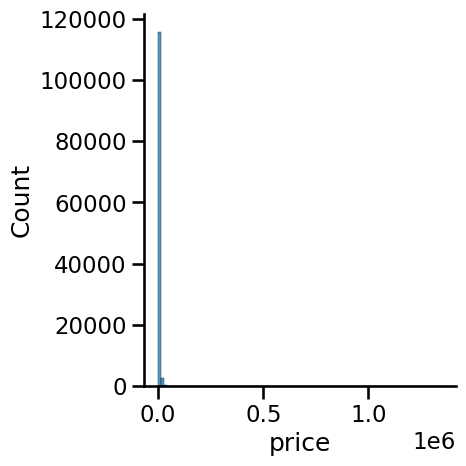

In [17]:
plt.figure(figsize=(9, 3))
sns.displot(x='price', data=diamond_prices, bins=100)
plt.show()

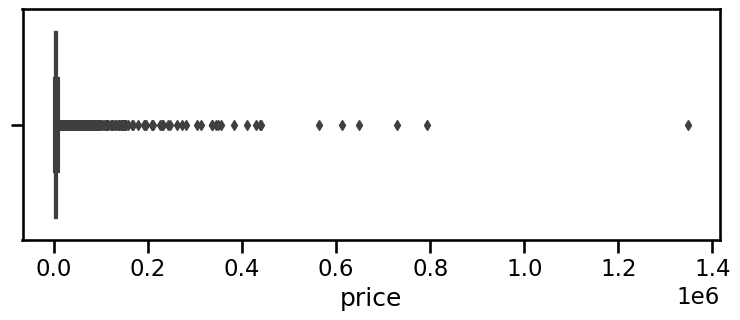

In [18]:
plt.figure(figsize=(9, 3))
sns.boxplot(x='price', data=diamond_prices)
plt.show()

The novelty here is not in the plots themselves; they are not any different from what you have seen before. What makes it novel is that the data used to create these plots is directly streamed from a cloud data store.

## Azure

Azure provides a convenient way to manage datasets using a feature called data assets. Data assets are built on top of `fsspec` and offer additional functionalities such as tracking and versioning of different datasets.

Unlike the actual data files stored in blob storage, data assets act as a lightweight wrapper that includes valuable metadata without incurring any extra cost. This allows us to register a dataset and easily update its version whenever new data is added.

In [5]:
for registered_data in ml_client.data.list():
    print(registered_data.name)

winequality-local
winequality-red
user-likes-media
socialmediaengagement
imdb_reviews
diamond-prices-jan
diamond-prices-feb
wine-quality-indicator
diamond-prices-may


In [20]:
registered_data_asset = ml_client.data.get(name="diamond-prices-jan", version=1)

In [21]:
registered_data_asset.path

'azureml://subscriptions/5bcad9c4-40fb-4136-b614-cc90116dd8b3/resourcegroups/tf/workspaces/cloud-teach/datastores/workspaceblobstore/paths/LocalUpload/1fd544f96a4f86d5c113930ea82e2f95/diamond-prices.csv'

Notice how the file path starts with `azureml://`, much like `s3://`. As is the case with S3, we will still need to allow `fsspec` to access the Azure credentials in order to interact with the cloud data store. Here is where the `azureml-fsspec` package comes in (`pip install azureml-fsspec`).

Once installed, we can use the same function `read_csv` from `pandas` to now point to the Azure ML data location and read the data as a Python object (this same function was pointing to a S3 location before).

In [22]:
diamond_prices = pd.read_csv(registered_data_asset.path)

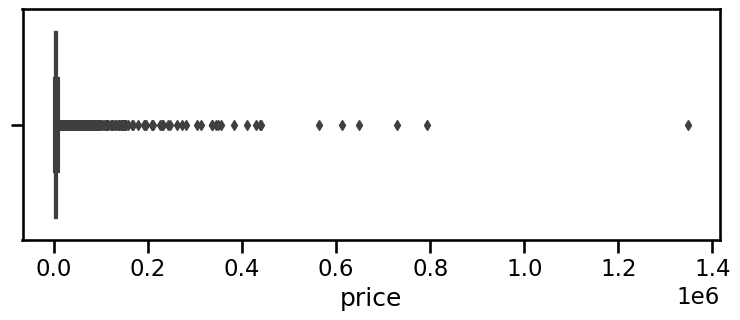

In [23]:
plt.figure(figsize=(9, 3))
sns.boxplot(x='price', data=diamond_prices)
plt.show()

## Data Ingress into Cloud

Up until now, we have focused on data files already residing in the cloud (S3 or Azure Blob Storage). But how does the data initially make its way into the data store? While the responsibility of handling data ingress from external sources into the cloud lies with data engineers, it's beneficial to view blob stores as services that can be leveraged by other services to upload data. 

Here are three examples of how data from external sources can be stored in cloud stores:

1. Data Extraction from Relational Databases: Suppose there is a scenario where transactions from an on-premise relational database need to be stored in AWS S3. In this case, a data extraction process can be implemented to query the database, summarize the relevant data, and then push it to an S3 bucket. This ensures that the transaction data is securely stored in the cloud for further analysis or archival purposes.

2. Real-time Data Streaming: Imagine a situation where a company collects real-time data from various sources, such as IoT devices or social media feeds, and wants to store it in Azure Blob Storage. In this scenario, a data streaming pipeline can be set up using technologies like Apache Kafka or Azure Event Hubs. The streaming pipeline continuously captures the incoming data, transforms it if necessary, and then stores it in Azure Blob Storage for immediate or later use.

3. Web Scraping and Data Ingestion: Web scraping is a common technique used to extract data from websites. Let's say there is a requirement to gather data from multiple websites and store it in AWS S3. To achieve this, a web scraping script can be developed using tools like BeautifulSoup or Scrapy. The script can crawl the targeted websites, extract the desired information, and finally push the scraped data to AWS S3, making it readily accessible for analysis or other applications.

In each of these examples, data from external sources is processed or extracted and then stored in cloud storage services like AWS S3, or Azure Blob Storage. These cloud stores offer scalability, durability, and accessibility, enabling efficient data storage and subsequent utilization in various cloud-based applications.

As an illustration of how external data can be written to cloud data stores (such as S3 or Azure Blob Store), let's examine the transfer of local data to these stores.

### AWS

Let's explore the process of copying an external dataset (in this case stored locally) to AWS S3 using the `sagemaker` session as the execution agent.

In [24]:
preprocessing_session.default_bucket()

'sagemaker-processing-example'

In [25]:
local_data_path = 'data/diamond-prices.csv'

In [26]:
s3_dataset_path = preprocessing_session.upload_data(
    path=local_data_path
)

In [27]:
print(f"Dataset uploaded to S3 location: {s3_dataset_path}")

Dataset uploaded to S3 location: s3://sagemaker-processing-example/data/diamond-prices.csv


Notice how the local directory path (`data/`) is replicated in the S3 bucket. 

### Azure

Let's explore the process of registering an external dataset as a data asset in the Azure ML environment. In this scenario, we will copy a local dataset to Azure blob storage and then proceed to register the file as a data asset.

In [28]:
local_data_path = 'data/diamond-prices.csv'

In [31]:
data_asset = Data(
    path=local_data_path,
    type=AssetTypes.URI_FILE,
    description="A dataset of diamond prices scraped from the Brilliant Earth website",
    name="diamond-prices-may",
    version="2"
)

In [32]:
ml_client.data.create_or_update(data_asset)

Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'diamond-prices-may', 'description': 'A dataset of diamond prices scraped from the Brilliant Earth website', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/5bcad9c4-40fb-4136-b614-cc90116dd8b3/resourceGroups/tf/providers/Microsoft.MachineLearningServices/workspaces/cloud-teach/data/diamond-prices-may/versions/2', 'Resource__source_path': None, 'base_path': '/home/pavankumargurazada/Desktop/GL/DSC/Week-3_ Data pre-processing/v2', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f3fc6e688e0>, 'serialize': <msrest.serialization.Serializer object at 0x7f3fc6e68cd0>, 'version': '2', 'latest_version': None, 'path': 'azureml://subscriptions/5bcad9c4-40fb-4136-b614-cc90116dd8b3/resourcegroups/tf/workspaces/cloud-teach/datastores/workspaceblob

Once the data asset is registered, it can be accessed and inspected as described in the previous section.

In [33]:
for registered_data in ml_client.data.list():
    print(registered_data.name)

winequality-local
winequality-red
user-likes-media
socialmediaengagement
imdb_reviews
diamond-prices-jan
diamond-prices-feb
wine-quality-indicator
diamond-prices-may


In summary, to execute EDA (Exploratory Data Analysis), we need to access data stored in the cloud and run ad-hoc aggregations on the data. The `fsspec` package simplifies this process by enabling common functions like `read_csv` to access cloud file systems just as easily as local file systems.

# Executing Processing Jobs

## The idea of a job

Exploratory data analysis often leads to the identification of data quality issues, which require a set of actions to be taken for correction. These actions, represented as a Python script, are executed on a compute cluster (a group of virtual machines) and referred to as a "job". A processing job runs the script on the designated compute cluster and saves the resulting output to cloud storage. Examples of typical preprocessing jobs are scaling or standardizing data, creating meaningful features based on raw data, and dropping rows that contain missing values.

Let us now see how processing jobs are executed on AWS and Azure.

## AWS SageMaker

### Creating an execution environment

In `sagemaker`, we utilize framework-specific preprocessors (such as `scikit-learn`, `TensorFlow`, `PyTorch`) to facilitate the necessary preprocessing steps. These preprocessors assist in achieving the desired data preparation. Preprocessing jobs are executed within a customized compute environment where all the required Python packages are preinstalled. It's important to note that this compute environment can be a cluster of machines. In `sagemaker`, there is a specific environment designed for `scikit-learn` called the `SKLearnProcessor` class.

In [34]:
sklearn_processor = SKLearnProcessor(
    framework_version="1.0-1",
    role=aws_role,
    instance_type="ml.t3.medium",
    instance_count=1,
    volume_size_in_gb=1,
    sagemaker_session=preprocessing_session
)

By using the `aws_role` as a parameter the processor assumes the execution role afforded by `sagemaker`. This processor assembles the specified compute (EC2) and the execution environment (Python + `scikit-learn`) and acts as a backbone on which processing scripts could be run. 

![aws-processing-job](assets/aws-processing-job.drawio.png)

Notice how we are specifying the type of compute instance, the number of instances we want in the cluster and the disk size of the instances. At this stage, all infrastructure we need to execute a processing job is in place.

By default, job artefacts (i.e., intended output from the execution of a specified script on inputs) are stored in the default bucket associated with the sagemaker session. However, we can specify a custom bucket to store specific job artifacts by changing the session parameters (as we did by creating a `processing_session` attached to a custom bucket). 

### Executing pre-processing jobs

When a preprocessing job is executed, there are certain data movement requirements. The data from S3 needs to be mapped to the compute cluster, and the output generated by the job must be stored persistently back to S3. To simplify this process, SageMaker has a mechanism in place.

[SageMaker maps inputs from S3 to a specific directory on the EC2 instances within a cluster](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html): `/opt/ml/processing/input`. This directory serves as the storage location for the input data. When a script is executed on the EC2 instance, it can access this directory, retrieve the necessary input data, perform the required processing steps, and store the resulting output artifacts in another directory: `/opt/ml/processing/output`.

It's important to note that all the data contained within the `/opt/ml/processing/output` directory is automatically copied to the bucket associated with the `sagemaker` session. This copying operation creates a subdirectory under the name of the job, ensuring proper organization and storage of the processed data.

![preprocessing](assets/aws-processing-map.drawio.png)

Note that `sagemaker` will create a compute cluster as needed and then remove it once the job is executed. If any output is not stored, it will be lost when the job is finished.

Let us now look at a couple of common pre-processing jobs to illustrate assembly and execution of data pre-processing pipelines using `sagemaker`. In these two examples, while the execution environment stays the same, the scripts that run on this environment will change from example to example.

#### Task 1: Train-Test Split

In this example, we read a dataset from a S3 folder and use a remote cluster to split the data set into train, validation and test. We save these three splits in the S3 bucket specified for this job above (`sagemaker-processing-example`).

In [35]:
sklearn_processor.run(
    code="aws/split.py",
    inputs=[
        ProcessingInput(input_name="full_data",
                        source=s3_dataset_path, 
                        destination="/opt/ml/processing/input")
    ],
    outputs=[
        ProcessingOutput(output_name="training_data", 
                         source="/opt/ml/processing/output/train"),
        ProcessingOutput(output_name="validation_data", 
                         source="/opt/ml/processing/output/validation"),
        ProcessingOutput(output_name="test_data", 
                         source="/opt/ml/processing/output/test"),
    ],
    job_name="2023-05-29-train-test-split-002",
    wait=False
)

INFO:sagemaker:Creating processing-job with name 2023-05-29-train-test-split-002


This above code is using the `sklearn_processor` object to execute a preprocessing script on SageMaker. Let's go through each part of the code:

1. `sklearn_processor.run`: This is a method that runs a processing job using the SageMaker Scikit-learn Processor.

2. `code="aws/split.py"`: Specifies the location of the preprocessing script file. In this case, the script is located at `aws/split.py`.

3. `inputs`: This is a list of `ProcessingInput` objects that represent the inputs for the preprocessing script. In the code provided, there is only one input specified:

   - `ProcessingInput(input_name="full_data", source=s3_dataset_path, destination="/opt/ml/processing/input")`: This input is named "full_data" and it specifies the source location of the input data, `s3_dataset_path`, which is an S3 path. The destination is set to `/opt/ml/processing/input`, which is the location within the processing container where the input data will be available.

4. `outputs`: This is a list of `ProcessingOutput` objects that represent the outputs generated by the preprocessing script. In the code provided, there are three outputs specified:

   - `ProcessingOutput(output_name="training_data", source="/opt/ml/processing/output/train")`: This output is named "training_data" and it specifies the source location of the training data output, which is set to `/opt/ml/processing/output/train`.
   
   - `ProcessingOutput(output_name="validation_data", source="/opt/ml/processing/output/validation")`: This output is named "validation_data" and it specifies the source location of the validation data output, which is set to `/opt/ml/processing/output/validation`.
   
   - `ProcessingOutput(output_name="test_data", source="/opt/ml/processing/output/test")`: This output is named "test_data" and it specifies the source location of the test data output, which is set to `/opt/ml/processing/output/test`.

5. `job_name="2023-05-29-train-test-split-002"`: Specifies a unique name for the processing job. In this case, the job name is set to "2023-05-29-train-test-split-002".

6. `wait=False`: This parameter indicates whether the `run` method should wait for the job to complete or return immediately. In this case, it is set to `False`, which means the method will return immediately without waiting for the job to finish.

In [36]:
sklearn_processor.latest_job.describe()

{'ProcessingInputs': [{'InputName': 'full_data',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-processing-example/data/diamond-prices.csv',
    'LocalPath': '/opt/ml/processing/input',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'code',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-processing-example/2023-05-29-train-test-split-002/input/code/split.py',
    'LocalPath': '/opt/ml/processing/input/code',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'training_data',
    'S3Output': {'S3Uri': 's3://sagemaker-processing-example/2023-05-29-train-test-split-002/output/training_data',
     'LocalPath': '/opt/ml/processing/output/train',
     'S3UploadMode': 'EndOfJob'},
    'AppManaged': False},
  

#### Task 2: Data Transformation

Let's create a processing pipeline that performs two data transformation steps: `StandardScaler()` on numeric features and `OneHotEncoder()` on categorical features. The script responsible for executing these transformation steps is called `transform.py`. It also splits the input data into training and testing sets.

In [37]:
sklearn_processor.run(
    code="aws/transform.py",
    inputs=[
        ProcessingInput(input_name="full_data",
                        source=s3_dataset_path, 
                        destination="/opt/ml/processing/input")
    ],
    outputs=[
        ProcessingOutput(output_name="training_data", 
                         source="/opt/ml/processing/output/train"),
        ProcessingOutput(output_name="test_data", 
                         source="/opt/ml/processing/output/test"),
    ],
    job_name="2023-05-29-data-transformation-002",
    wait=False
)

INFO:sagemaker:Creating processing-job with name 2023-05-29-data-transformation-002


Notice how the only major difference from the previous subsection is the script that needs to be run. The mapping from input to the cluster and the output from the cluster to a S3 bucket always follows the same pattern. The folder mapping (i.e., `/opt/*`) that enables persistent data storage execution is always the same.

In [38]:
sklearn_processor.latest_job.describe()

{'ProcessingInputs': [{'InputName': 'full_data',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-processing-example/data/diamond-prices.csv',
    'LocalPath': '/opt/ml/processing/input',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'code',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-processing-example/2023-05-29-data-transformation-002/input/code/transform.py',
    'LocalPath': '/opt/ml/processing/input/code',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'training_data',
    'S3Output': {'S3Uri': 's3://sagemaker-processing-example/2023-05-29-data-transformation-002/output/training_data',
     'LocalPath': '/opt/ml/processing/output/train',
     'S3UploadMode': 'EndOfJob'},
    'AppManaged': 

## Azure ML

Mapping data stored in Azure ML blob stores to compute clusters works similarly to SageMaker, but without the need to specify a particular location in the ephemeral compute cluster. Instead, registered data can be referenced using the dataset name and version.

To demonstrate a preprocessing pipeline on Azure ML, we will take data from a registered data asset and bring it into a compute cluster. In this process, we will execute the `transform.py` script, which accesses the input data and generates multiple outputs. The main distinction from running this process on AWS is that the inputs and outputs are parameterized, and the compute clusters are aware of the Azure ML compute paths.

![azure-processing](assets/azure-processing-map.drawio.png)

In [68]:
for datastore in ml_client.datastores.list():
    print(datastore.name)

stagingarea
azureml_globaldatasets
workspaceworkingdirectory
workspaceartifactstore
workspacefilestore
workspaceblobstore


In [69]:
datastore_path = "azureml://datastores/workspaceblobstore/paths/training-data/"

In [70]:
my_job_inputs = {
    "input_data": Input(type=AssetTypes.URI_FILE, 
                        path="azureml:diamond-prices-jan:1")
}

my_job_outputs = {
    "output_datastore": Output(type=AssetTypes.URI_FOLDER,
                               path=datastore_path)
}

In [71]:
job = command(
    code="./azure",
    command="python transform.py --input_data ${{inputs.input_data}} --output_datastore ${{outputs.output_datastore}}",
    inputs=my_job_inputs,
    outputs=my_job_outputs,
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest",
    compute="c002",
    experiment_name="2023-05-29_test-train-split-experiment-002",
    display_name="test-train-split-experiment-002"
)

In [72]:
ml_client.create_or_update(job)

Uploading azure (0.0 MBs): 100%|██████████| 2010/2010 [00:00<00:00, 70437.14it/s]


INFO:azure.identity._internal.interactive:InteractiveBrowserCredential.get_token succeeded
INFO:azure.identity._credentials.default:DefaultAzureCredential acquired a token from InteractiveBrowserCredential


Experiment,Name,Type,Status,Details Page
2023-05-29_test-train-split-experiment-002,sharp_airport_6r3fq6fkts,command,Starting,Link to Azure Machine Learning studio


In [77]:
ml_client.jobs.get("sharp_airport_6r3fq6fkts")

INFO:azure.identity._internal.interactive:InteractiveBrowserCredential.get_token succeeded
INFO:azure.identity._credentials.default:DefaultAzureCredential acquired a token from InteractiveBrowserCredential


Experiment,Name,Type,Status,Details Page
2023-05-29_test-train-split-experiment-002,sharp_airport_6r3fq6fkts,command,Completed,Link to Azure Machine Learning studio


The Azure Machine Learning Studio page linked above provides references to the data generated using the `transform.py` script. To confirm the contents of the output data, we can examine the output datastore mentioned in the job details.